# Aprendizado por reforço

In [78]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation

No aprendizado por reforço, um agente de sofware faz observações e realiza ações dentro de um ambiente, e em troca recebe recompensas. 
> Seu intuito é aprender a agir de forma a maximizar as recompensas esperadas ao longo do tempo.

Exemplo:
1. Controlar um robo.
2. Games.
3. Pode analizar os preços do mercado de ações e decidir quanto comprar ou vender a cada segundo.

## Pesquisa de políticas
O algoritmo que um agente de software usa para determinar suas ações se chama politicas.

Pesquisa de policas : encontrar o melhor conjunto de parametros
> É muito grande

## Introduçao GYM

Um dos desafios do aprendizado por reforço é que, para treinar um agente, é necessário um ambiente de trabalho.
> O ambiente de treinamento real é conplexo e lento, se faz necessario um `ambiente simulado`

In [79]:
import gym
import gymnasium as gym

> instale gym e gyamnasium

In [80]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

In [81]:
obs = env.reset()

In [82]:
obs

(array([-0.00250181,  0.02415668, -0.04996036,  0.01798457], dtype=float32),
 {})

> `CartPole`, simula um ambiente 2d na qual podemos acelerar um carrinho para a esquerda ou para a direita a fim de equilibrar uma haste em cima dela

* Inicializa com o metodo `.reset()` que retorna a primeira observação
* A observação é uma array com 4 floats: Represanta a posiçaõ do carrinho
    1. Posição do carrinho
    2. Sua velocidade 
        * Positivo : direita
        * Negativo : esquerda
    3. Angulo da aste
    4. Velocidade angular

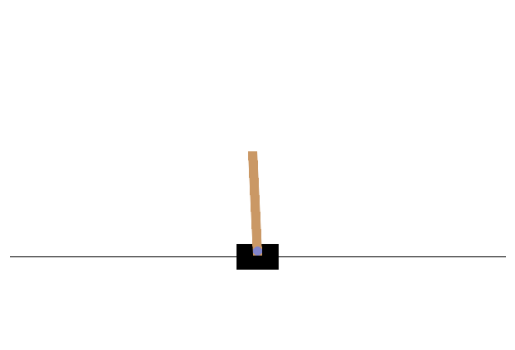

In [83]:
plt.imshow(env.render())
plt.axis('off')
plt.show()

Perguntado ao ambiente quais as possivei ações

In [84]:
env.action_space

Discrete(2)

> Significa que as ações possiveis são 0 e 1, que representa a aceleração para esquerda(0) e direita (1)

In [85]:
action = 1 # acelera para a direita

In [86]:
result = env.step(action)

In [87]:
obs , reward, done, _, info = result

In [88]:
obs

array([-0.00201868,  0.2199582 , -0.04960067, -0.29003346], dtype=float32)

`Obs` : É uma nova observação. 
    * Agora o carrinho está se movimenta para direita `obs[1]` > 0
    * Haste inclinda para esquerda `obs[2]` < 0
    * Sua verlocidade angular é negativa `obs[3]` < 0

In [89]:
reward

1.0

`reward` : recompensa 1 a cada intervalo, seja lo que voce faça.

In [90]:
done

False

`done` : 	Episódio terminou porque atingiu uma condição natural de fim do ambiente (por exemplo, caiu o pêndulo, completou a corrida, perdeu todas as vidas).

In [91]:
info

{}

In [92]:
def basic_policy(obs):
    try:
        angle = obs[0][2]
    
        return 0 if angle < 0 else 1
    except:
        angle = obs[2]

        return 0 if angle < 0 else 1

In [93]:
def simulate(obs, is_frame=False, step_frame=1):
    total, frames = [], []

    for episode in range(500):
        episode_reward = 0
        obs = env.reset()
        for step in range(200):
            if is_frame and episode == step_frame:
                frames.append(env.render())

            action = basic_policy(obs)
            obs, reward, done, _ ,info = env.step(action)
            episode_reward += reward
            if done:
                break
        total.append(episode_reward)

    return total, frames

In [94]:
total = simulate(obs, is_frame=True)[0]

In [95]:
S = f'''
Resultados para 500 episodios com 200 passos
Media: {np.mean(total)}
Desvio: {np.std(total)}
Maximo: {np.max(total)}
Minimo: {np.min(total)}
'''
print(S)


Resultados para 500 episodios com 200 passos
Media: 40.93
Desvio: 8.749462840654848
Maximo: 66.0
Minimo: 24.0



In [96]:
_, frames = simulate(obs, is_frame=True)

In [97]:
len(frames)

46

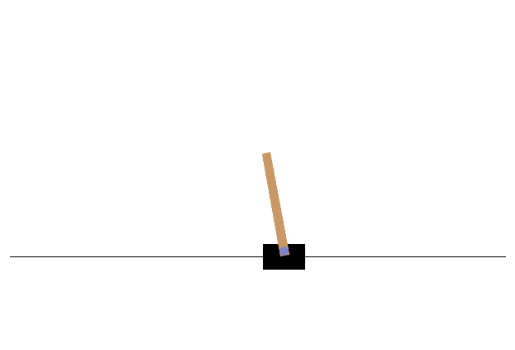

In [98]:
# Criar figura
fig, ax = plt.subplots()
img = ax.imshow(frames[0])
ax.axis("off")

# Função para atualizar os frames
def update(i):
    img.set_array(frames[i])
    return [img]

# Criar animação (IMPORTANTE: manter a referência `ani`)
ani = animation.FuncAnimation(
    fig, update, frames=len(frames), interval=100, blit=True, repeat=False
)
from IPython.display import HTML
HTML(ani.to_jshtml())

## Politicas de rede neural

A nede neural tomará uma observação como entrada e gerará como saída a ação a ser executada. Em termos mais precisos, ela estimara uma prob para cada ação e em seguida **selecionaremos um ação aleatóriamente,de acordo com a probalidades estimadas**

> Porque escolher uma ação aleatória? 
> Esta abordagem permite o equilibrio certo entre novas ações e explorar ações que funcionam bem.

In [99]:
def model_1(n_inputs):
    return keras.models.Sequential([
        keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
        keras.layers.Dense(1, activation='sigmoid')
    ])

### Avaliação de ações

`Problema de atribuição de crédito` : Quando o agente recebe uma recompensa, é dificil saber quais ações devem ser creditadas ou culpadas a ele.

#### Fator de desconto

* O **fator de desconto** (γ, *gamma*) é um número entre 0 e 1 que determina o quanto o agente valoriza **recompensas futuras** em relação às recompensas imediatas.
* Se relacionarmos isso a *aprendizado humano ou esforço*, γ funcionaria como um peso sobre o **benefício futuro do esforço atual**.

📌 Analogia com esforço:

* **γ próximo de 0** → o aprendiz só se importa com ganhos imediatos, não persistindo em tarefas longas (esforço curto).
* **γ próximo de 1** → o aprendiz valoriza fortemente o benefício futuro, disposto a investir esforço mesmo sem resultados imediatos.

💡 Fórmula geral em RL:

$$
R_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k}
$$

* $R_t$: retorno total esperado no tempo *t*
* $r_{t+k}$: recompensa no tempo $t+k$
* γ: fator de desconto do "valor futuro"

Se traduzirmos para esforço, poderíamos interpretar $r_{t+k}$ como *ganho de conhecimento ou benefício obtido* e γ como *paciência ou visão de longo prazo* diante do esforço.

Se você quiser, posso montar **um modelo matemático simples que quantifica “aprendizado acumulado” em função do esforço e do fator de desconto** para ver como a curva muda dependendo de γ. Isso deixaria bem visual a relação. Quer que eu faça?


In [100]:
# fator de desconto

def fator_desconto(valores, gamma):
    return [gamma**i * valor for i, valor in enumerate(valores)]

In [101]:
valor = [10, -50]

In [102]:
a = fator_desconto(valor, 0.9)
a

[10.0, -45.0]

In [103]:
sum(a)

-35.0

In [104]:
b = fator_desconto(valor, 0.1)
b

[10.0, -5.0]

In [105]:
sum(b)

5.0

> é uma função que mede o quanto melhor ou pior uma ação é em relação à média das ações possíveis naquele estado.

### Gradiente de política

1. Deixa a politica de rede neural jogar o jogo diversas vezes e a cada intervalo, calcule os gradientesque tornariam a ação escolhida ainda mais provavel (não aplique ainda os gradientes)
2. Depois de rodas vários episodios, calcule a vantagem de cada ação
3. Se a vantagem for possitiva, provalvemente a açao foi boa e voce aplicara os gradientes calculados anteriormente oara tomaar a ação ainda mais provavel de ser escolhida no futuro, se for negativa significa que ação foi ruim e voce aplicara os gradientes opostos para tomar esta ação menos provevel no futuro.
4. Calcule a media de todos os vetores de gradientes resultantes ea utilize para executar o gradiente descente.

In [134]:
def joga_uma_partida(env, obs, model: keras.Model, loss_fn):
    with tf.GradientTape() as tape:
        try:
            left_prob = model(obs[np.newaxis])
        except:
            left_prob = model(obs[0][np.newaxis])
        # ação
        action = int(tf.random.uniform([1, 1]) > left_prob)
        y_target = tf.constant([[1.]], dtype=tf.float32) - tf.cast(action, dtype=tf.float32)

        # perda
        loss = tf.reduce_mean(loss_fn(y_target, left_prob))
    
    grad = tape.gradient(loss, model.trainable_variables)

    obs, reward, done, _, _ = env.step(action)
    return obs, reward, done, grad

In [135]:
def joga_multi_episodios(env, model: keras.Model, loss_fn, n_episodes, max_steps):

    all_rewards, all_grads = [], []

    for episode in range(n_episodes):
        current_reward, current_grads = [], []

        obs = env.reset()

        for step in range(max_steps):
            obs, reward, done, grad = joga_uma_partida(env, obs, model, loss_fn)

            current_reward.append(reward)
            current_grads.append(grad)

            if done:
                break

        all_rewards.append(current_reward)
        all_grads.append(current_grads)

    return all_rewards, all_grads    

> Retorna uma lista de recompensas, bem como uma lista de gradientes por episodio

In [136]:
def discont_rewards(rewards, fator_desconto_):

    disconto = np.array(rewards)
    for i in range(1, len(rewards)):
        disconto[i] += disconto[i-1] * fator_desconto_

    return disconto

In [137]:
def discont_and_normalize(all_rewards, fator_desconto_):
    all_disconted_rewards = [discont_rewards(rewards, fator_desconto_) for rewards in all_rewards]

    flat_rewards = np.concatenate(all_disconted_rewards)

    mean_ = flat_rewards.mean()
    std = flat_rewards.std()

    return [(rewards - mean_) / std for rewards in all_disconted_rewards]

In [138]:
# exemplo 
valores = [10, 0, -50]

print(discont_rewards(valores, 0.9))
print(discont_rewards(valores, 0.1))
print(discont_rewards(valores, 0.99))

[ 10   9 -41]
[ 10   1 -49]
[ 10   9 -41]


In [139]:

valores = [
    [11, 0, -50],
    [10, 20]
]

print(discont_and_normalize(valores, 0.9))
print(discont_and_normalize(valores, 0.1))
print(discont_and_normalize(valores, 0.5))

[array([ 0.31501057,  0.22987258, -1.89857724]), array([0.27244158, 1.08125251])]
[array([ 0.49341383,  0.08897626, -1.93321157]), array([0.45297008, 0.8978514 ])]
[array([ 0.41118337,  0.1693108 , -1.92691814]), array([0.37087127, 0.9755527 ])]


#### Treinando 

In [140]:
n_iter = 150
n_episodios_por_atualizacao = 10
max_steps = 200

fator_desconto_ = 0.9

In [141]:
model = model_1(4)

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [142]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

In [143]:
env = gym.make('CartPole-v1')

obs = env.reset()

In [144]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

loss_fn = keras.losses.binary_crossentropy

In [145]:
for i in range(n_iter):
    all_rewards, all_grads = joga_multi_episodios(env, model, loss_fn, n_episodios_por_atualizacao, max_steps)

    all_final_rewards = discont_and_normalize(all_rewards, fator_desconto_)

    all_mean_grads = []

    for var_index in range(len(model.trainable_variables)):
        grads_list = []
        
        for episode_index, final_rewards in enumerate(all_final_rewards):
            for step, final_reward in enumerate(final_rewards):
                grads_list.append(final_reward * all_grads[episode_index][step][var_index])
        mean_grads = tf.reduce_mean(grads_list)

        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

In [147]:
env.close()

In [165]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render())
        try:
            obs = obs.reshape(1, -1)
        except:
            obs = obs[0].reshape(1, -1)
        left_proba = model.predict(obs)
        action = int(np.random.rand() > left_proba)
             
        obs, reward, done, _ ,info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [166]:
frames = render_policy_net(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


C:\Users\mateu\AppData\Local\Temp\ipykernel_10380\3692039842.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  action = int(np.random.rand() > left_proba)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1

In [168]:
len(frames)

41

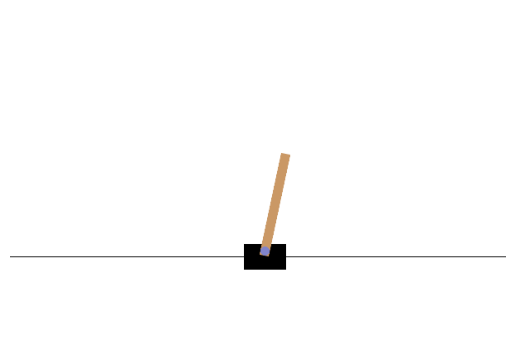

In [169]:
# Criar figura
fig, ax = plt.subplots()
img = ax.imshow(frames[0])
ax.axis("off")

# Função para atualizar os frames
def update(i):
    img.set_array(frames[i])
    return [img]

# Criar animação (IMPORTANTE: manter a referência `ani`)
ani = animation.FuncAnimation(
    fig, update, frames=len(frames), interval=100, blit=True, repeat=False
)
from IPython.display import HTML
HTML(ani.to_jshtml())

## Processos de Decisão de Markov